In [1]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt

import psycopg2
import pandas as pd

In [2]:
PATH1 = "../../data/db/"

PATH2 = "xray/"
PATH3 = "/merged/"

# Connect to postgres

In [3]:
# pip install psycopg2
#%%


# Establish a connection to the PostgreSQL database
try:
    connection = psycopg2.connect(
        host="localhost",
        database="postgres",
        user="postgres",
        password=""         #add here the password
    )
    print("Connected successfully")
except:
    print("NOT able to connect to the database")

# Create a cursor object
cur = connection.cursor()

Connected successfully


# Functions

In [4]:
######### FUNCTIONS ##########

# function to run sql queries
def run_query(cursor, query, params=None):
    cursor.execute(query, params)
    return cursor.fetchall()

# function to transform from query to df
def query_to_df(cursor, query, params=None):
    # Run the query using the run_query() function
    results = run_query(cursor, query, params)
    column_names = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(results, columns=column_names)
    return df

# Available schemas: mimiciv_note, mimiciv_hosp, mimic_cxr_sr 

# Queries

## Probably not necessary

In [5]:
########### Execute SQL queries  ########
# commenting this because running takes a lot of time and not necessary 

# To take poe dicom_metad from hosp
# query = """
#             SELECT *
#             FROM mimiciv_hosp.poe
#             ORDER BY poe_seq
#         """
# poe = query_to_df(cur, query)
# print(poe.head().to_string())


In [6]:
# To merge procedure_icd (with icd code)  from mimic-iv hosp patients with cxr based on subject_id
# This will create lots of duplicate for each subject since we don't have admission id so not very useful
# query = """
#             SELECT *
#             FROM (
#                 SELECT * 
#                 FROM mimic_cxr_sr.cxr_record_list 
#             ) AS cxr_record_list
#             JOIN (
#                 SELECT *
#                 FROM mimiciv_hosp.procedures_icd
#             ) AS procedures_icd
#             ON cxr_record_list.subject_id = procedures_icd.subject_id
#         """
# m_icd_cxr = query_to_df(cur, query)
# print(m_icd_cxr.head().to_string())

In [7]:
# To take cxr_record_list from mimic_cxr_sr
# query = """
#             SELECT *
#             FROM mimic_cxr_sr.cxr_record_list
#             ORDER BY subject_id
#         """
# cxr_record_list = query_to_df(cur, query)
# print(cxr_record_list.head().to_string())

### To select clinical notes and subjects with general x-ray

In [8]:
# To merge discharge note with poe (mimic-iv) based on subject_id and hadm_id
# query = """
#             SELECT *
#             FROM (
#                 SELECT poe_id, poe_seq, subject_id, hadm_id, ordertime, order_type, order_subtype
#                 FROM mimiciv_hosp.poe 
#             ) AS poe
#             JOIN (
#                 SELECT *
#                 FROM mimiciv_note.discharge
#             ) AS discharge_note
#             ON poe.subject_id = discharge_note.subject_id
#             AND poe.hadm_id = discharge_note.hadm_id
#         """

# gxray_notes = query_to_df(cur, query)
# print(gxray_notes.head().to_string())

#time on windows

# From mimic-iv

In [5]:
# To select only the general xray and columns: poe_id, poe_seq, subject_id, hadm_id, ordertime, order_type, order_subtype
query = """
    SELECT poe_id, poe_seq, subject_id, hadm_id, ordertime, order_type, order_subtype
    FROM mimiciv_hosp.poe
    WHERE order_subtype = 'General Xray'
    ORDER BY subject_id, hadm_id, poe_seq
"""
gxray = query_to_df(cur, query)
print(gxray.head().to_string())


         poe_id  poe_seq  subject_id   hadm_id           ordertime order_type order_subtype
0   10000032-14       14    10000032  22595853 2180-05-06 20:53:47  Radiology  General Xray
1   10000032-14       14    10000032  22595853 2180-05-06 20:53:47  Radiology  General Xray
2   10000032-66       66    10000032  22841357 2180-06-26 17:06:07  Radiology  General Xray
3   10000032-66       66    10000032  22841357 2180-06-26 17:06:07  Radiology  General Xray
4  10000032-222      222    10000032  25742920 2180-08-05 23:32:59  Radiology  General Xray


# From mimic-cxr

In [6]:
# To select metadata from cxr
query = """
    SELECT *
    FROM mimic_cxr_sr.dicom_metadata
    ORDER BY subject_id
"""
dicom_metad = query_to_df(cur, query)
print(dicom_metad.head().to_string())

                                       dicom_id  subject_id  study_id PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate           StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning PatientOrientationCodeSequence_CodeMeaning
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267                CHEST (PA AND LAT)           PA  3056     2544   21800506  213014.53100000002                CHEST (PA AND LAT)             postero-anterior                                      Erect
1  174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267                CHEST (PA AND LAT)      LATERAL  3056     2544   21800506  213014.53100000002                CHEST (PA AND LAT)                      lateral                                      Erect
2  2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527                CHEST (PA AND LAT)           PA  3056     2544   21800626          165500.312                CHEST (PA AND L

# Transforming

In [11]:
# Convert and split 'ordertime' column into 'date' and 'time' columns
gxray[['StudyDate', 'time']] = gxray['ordertime'].astype(str).str.split(' ', expand=True)

# Display the resulting DataFrame
print(gxray.head().to_string())

         poe_id  poe_seq  subject_id   hadm_id           ordertime order_type order_subtype   StudyDate      time
0   10000032-14       14    10000032  22595853 2180-05-06 20:53:47  Radiology  General Xray  2180-05-06  20:53:47
1   10000032-14       14    10000032  22595853 2180-05-06 20:53:47  Radiology  General Xray  2180-05-06  20:53:47
2   10000032-66       66    10000032  22841357 2180-06-26 17:06:07  Radiology  General Xray  2180-06-26  17:06:07
3   10000032-66       66    10000032  22841357 2180-06-26 17:06:07  Radiology  General Xray  2180-06-26  17:06:07
4  10000032-222      222    10000032  25742920 2180-08-05 23:32:59  Radiology  General Xray  2180-08-05  23:32:59


In [12]:
# Convert 'StudyDate' and 'StudyTime' columns in dicom_metad to datetime format
dicom_metad['StudyDate'] = pd.to_datetime(dicom_metad['StudyDate'], format='%Y%m%d')

# Convert the time column to a string
dicom_metad['StudyTime'] = dicom_metad['StudyTime'].astype(str)
# dicom_metad['time_part'] = dicom_metad['StudyTime'].str.split('.').str[0]  #to get part before dot

# Extract the part before the dot and convert time values
dicom_metad['time_formatted'] = dicom_metad['StudyTime'].str.split('.').str[0].apply(lambda x: x.zfill(6)).apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:6]}')

# Combine 'StudyDate' and 'StudyTime' columns to create 'time_and_date' column in dicom_metad
dicom_metad['StudyDateTime'] = pd.to_datetime(dicom_metad['StudyDate'].astype(str) + " " + dicom_metad['time_formatted'].astype(str))
print(dicom_metad.head().to_string())

                                       dicom_id  subject_id  study_id PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate           StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning PatientOrientationCodeSequence_CodeMeaning time_formatted       StudyDateTime
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267                CHEST (PA AND LAT)           PA  3056     2544 2180-05-06  213014.53100000002                CHEST (PA AND LAT)             postero-anterior                                      Erect       21:30:14 2180-05-06 21:30:14
1  174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267                CHEST (PA AND LAT)      LATERAL  3056     2544 2180-05-06  213014.53100000002                CHEST (PA AND LAT)                      lateral                                      Erect       21:30:14 2180-05-06 21:30:14
2  2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527                CHE

# Merging based on same date and subject to obtain hadm_id and poe info


In [ ]:
# print('Size dicom_metad: ', dicom_metad.shape)  #(377110, 14)
# print('Size gxray: ', gxray.shape)    #(1491354, 15)

In [ ]:
# Convert to same datetime type
dicom_metad['StudyDate'] = pd.to_datetime(dicom_metad['StudyDate'])
gxray['StudyDate'] = pd.to_datetime(gxray['StudyDate'])

# Concatenate 'gxray' and 'dicom_metad' DataFrames based on same 'date' and 'subject_id'
gxray_dicom = pd.merge(dicom_metad, gxray, on=['subject_id', 'StudyDate'], how='inner')

# Display the resulting concatenated DataFrame
print(gxray_dicom.head().to_string())

                                       dicom_id  subject_id  study_id PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate           StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning PatientOrientationCodeSequence_CodeMeaning time_formatted       StudyDateTime       poe_id  poe_seq   hadm_id           ordertime order_type order_subtype transaction_type discontinue_of_poe_id discontinued_by_poe_id order_provider_id order_status      time
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267                CHEST (PA AND LAT)           PA  3056     2544 2180-05-06  213014.53100000002                CHEST (PA AND LAT)             postero-anterior                                      Erect       21:30:14 2180-05-06 21:30:14  10000032-14       14  22595853 2180-05-06 20:53:47  Radiology  General Xray              New                  None                   None            P9705S     Inactive  20:53:47
1  02aa804e-bde0afdd-112c0b34-7b

In [ ]:
print('Size gxray_dicom: ', gxray_dicom.shape)  #(678042, 27)

Size gxray_dicom:  (678042, 26)


## Remove duplicates

In [ ]:
#removing duplicates row based on dicom_id
duplicates = gxray_dicom.duplicated(subset='dicom_id', keep='first')
gxray_dicom = gxray_dicom[~duplicates]  #shape (215741, 28)

## Editing columns in gxray_dicom

In [ ]:
#moving column time next to study time
time = gxray_dicom.pop('time')
gxray_dicom.insert(gxray_dicom.columns.get_loc('time_formatted') + 1, 'time', time)

In [ ]:
print(gxray_dicom.head().to_string())

                                       dicom_id  subject_id  study_id PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate           StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning PatientOrientationCodeSequence_CodeMeaning time_formatted      time       StudyDateTime        poe_id  poe_seq   hadm_id           ordertime order_type order_subtype transaction_type discontinue_of_poe_id discontinued_by_poe_id order_provider_id order_status
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267                CHEST (PA AND LAT)           PA  3056     2544 2180-05-06  213014.53100000002                CHEST (PA AND LAT)             postero-anterior                                      Erect       21:30:14  20:53:47 2180-05-06 21:30:14   10000032-14       14  22595853 2180-05-06 20:53:47  Radiology  General Xray              New                  None                   None            P9705S     Inactive
2  174413ec-4ec4c1f7-34ea26b7-

## Adding difference in time  between time formatted and time

Time formatted = 
Time = 

In [ ]:
from datetime import datetime, timedelta
#adding cols to see difference in time between time formatted and time
gxray_dicom['time_formatted'] = pd.to_timedelta(gxray_dicom['time_formatted'])
gxray_dicom['time'] = pd.to_timedelta(gxray_dicom['time'])


# Calculate time difference in seconds
gxray_dicom['time_diff_seconds'] = (gxray_dicom['time_formatted'] - gxray_dicom['time']).dt.total_seconds()

# Format time difference as time string
gxray_dicom['time_diff'] = pd.to_datetime(gxray_dicom['time_diff_seconds'], unit='s').dt.strftime('%H:%M:%S')


#add column next to time
gxray_dicom.insert(gxray_dicom.columns.get_loc('time') + 1, 'time_diff', gxray_dicom.pop('time_diff'))

#add column next to time_diff
gxray_dicom.insert(gxray_dicom.columns.get_loc('time') + 1, 'time_diff_seconds', gxray_dicom.pop('time_diff_seconds'))

In [ ]:
print(gxray_dicom.head().to_string())

                                       dicom_id  subject_id  study_id PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate           StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning PatientOrientationCodeSequence_CodeMeaning  time_formatted            time  time_diff_seconds time_diff       StudyDateTime        poe_id  poe_seq   hadm_id           ordertime order_type order_subtype transaction_type discontinue_of_poe_id discontinued_by_poe_id order_provider_id order_status
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267                CHEST (PA AND LAT)           PA  3056     2544 2180-05-06  213014.53100000002                CHEST (PA AND LAT)             postero-anterior                                      Erect 0 days 21:30:14 0 days 20:53:47             2187.0  00:36:27 2180-05-06 21:30:14   10000032-14       14  22595853 2180-05-06 20:53:47  Radiology  General Xray              New                  None             

## Saving DFs

In [ ]:

# dicom_metad.to_csv(PATH1+PATH2+"dicom_metad.csv")
# gxray.to_csv(PATH1+PATH2+"gxray.csv")
gxray_dicom.to_csv(PATH1+PATH2+"gxray_dicom.csv")

# Feature Engineering: AGE

In [7]:
# Therefore, the age of a patient = hospital admission time - anchor_year + anchor_age


query = """
    SELECT DISTINCT
        admis.subject_id,
        admis.admittime,
        admis.hadm_id,
        EXTRACT(year FROM admis.admittime) AS admit_year,
        EXTRACT(month FROM admis.admittime) AS admit_month,
        EXTRACT(day FROM admis.admittime) AS admit_day,
        pat.anchor_year,
        pat.anchor_age,
        DATE_PART('year', admis.admittime::DATE) - pat.anchor_year + pat.anchor_age AS age
    FROM
        mimiciv_hosp.admissions admis
    INNER JOIN
        mimiciv_hosp.patients pat ON admis.subject_id = pat.subject_id    
                                AND EXTRACT(year FROM admis.admittime) = pat.anchor_year
"""

age_q = query_to_df(cur, query)
print(age_q.head(100).to_string())


    subject_id           admittime   hadm_id admit_year admit_month admit_day  anchor_year  anchor_age   age
0     10000032 2180-05-06 22:23:00  22595853       2180           5         6         2180          52  52.0
1     10000032 2180-06-26 18:27:00  22841357       2180           6        26         2180          52  52.0
2     10000032 2180-07-23 12:35:00  29079034       2180           7        23         2180          52  52.0
3     10000032 2180-08-05 23:44:00  25742920       2180           8         5         2180          52  52.0
4     10000068 2160-03-03 23:16:00  25022803       2160           3         3         2160          19  19.0
5     10000084 2160-11-21 01:56:00  23052089       2160          11        21         2160          72  72.0
6     10000084 2160-12-28 05:11:00  29888819       2160          12        28         2160          72  72.0
7     10000108 2163-09-27 23:17:00  27250926       2163           9        27         2163          25  25.0
8     10000248 2192

In [26]:

total_rows = age_q.shape[0]
print("Total rows:", total_rows)  #218614   

Total rows: 218614


# Feature Engineering: BMI

In [7]:
# #checking the unique value present in chartime to fins out if bmi is present
# query = """
#     SELECT DISTINCT
#         ch_events.valueuom AS unique_name
#     FROM
#         mimiciv_icu.chartevents ch_events
# """
# unique_names = query_to_df(cur, query)
# print(unique_names.head(1000).to_string())  #max 58 different measurements

# #here we can see that bmi is not present but kg and cm yes. But the values are wrong/unrealistic so not reliable.


In [8]:
#extract subject_id, chartdate, result_name from hosp > omr when result_name == BMI (kg/m2)
#from chardate extract anchor_year
#add bmi column merging based on subject_id and anchor_year


query = """
    SELECT
        omr.subject_id,
        omr.chartdate,
        EXTRACT(year FROM omr.chartdate) AS anchor_year,
        EXTRACT(month FROM omr.chartdate) AS anchor_month,
        EXTRACT(day FROM omr.chartdate) AS anchor_day,
        result_name,
        result_value AS bmi
    FROM
        mimiciv_hosp.omr omr
    WHERE
        omr.result_name = 'BMI (kg/m2)'
"""

bmi_q = query_to_df(cur, query)
print(bmi_q.head(100).to_string())

    subject_id   chartdate anchor_year anchor_month anchor_day  result_name   bmi
0     10000032  2180-05-07        2180            5          7  BMI (kg/m2)  18.0
1     10000032  2180-05-25        2180            5         25  BMI (kg/m2)  18.6
2     10000032  2180-06-01        2180            6          1  BMI (kg/m2)  18.7
3     10000032  2180-06-22        2180            6         22  BMI (kg/m2)  18.9
4     10000032  2180-06-27        2180            6         27  BMI (kg/m2)  19.2
5     10000032  2180-06-30        2180            6         30  BMI (kg/m2)  18.0
6     10000032  2180-07-09        2180            7          9  BMI (kg/m2)  18.7
7     10000032  2180-08-06        2180            8          6  BMI (kg/m2)  18.2
8     10000084  2160-11-21        2160           11         21  BMI (kg/m2)  24.4
9     10000117  2175-09-08        2175            9          8  BMI (kg/m2)  19.6
10    10000117  2176-02-10        2176            2         10  BMI (kg/m2)  20.8
11    10000117  

# Merging BMI and AGE in same table

In [54]:
query = """
    SELECT query1.subject_id,
           query1.admittime,
           query1.hadm_id,
           query1.admit_year,
           query1.admit_month,
           query1.admit_day,
           query1.age,
           query2.bmi
    FROM (
        SELECT DISTINCT
            admis.subject_id,
            admis.admittime,
            admis.hadm_id,
            EXTRACT(year FROM admis.admittime) AS admit_year,
            EXTRACT(month FROM admis.admittime) AS admit_month,
            EXTRACT(day FROM admis.admittime) AS admit_day,
            pat.anchor_year,
            pat.anchor_age,
            DATE_PART('year', admis.admittime::DATE) - pat.anchor_year + pat.anchor_age AS age
        FROM
            mimiciv_hosp.admissions admis
        INNER JOIN
            mimiciv_hosp.patients pat ON admis.subject_id = pat.subject_id    
                                    AND EXTRACT(year FROM admis.admittime) = pat.anchor_year
    ) AS query1
    INNER JOIN (
        SELECT DISTINCT
            omr.subject_id,
            omr.chartdate,
            EXTRACT(year FROM omr.chartdate) AS anchor_year,
            EXTRACT(month FROM omr.chartdate) AS anchor_month,
            EXTRACT(day FROM omr.chartdate) AS anchor_day,
            omr.result_name,
            omr.result_value AS bmi
        FROM
            mimiciv_hosp.omr omr
        WHERE
            omr.result_name = 'BMI (kg/m2)'
    ) AS query2
    ON query1.subject_id = query2.subject_id
    AND query1.admit_year = query2.anchor_year
    AND query1.admit_month = query2.anchor_month
    AND query1.admit_day = query2.anchor_day
"""

merged_bmi_age = query_to_df(cur, query)
print(merged_bmi_age.head(100).to_string())


    subject_id           admittime   hadm_id admit_year admit_month admit_day   age     bmi
0     10000084 2160-11-21 01:56:00  23052089       2160          11        21  72.0    24.4
1     10000248 2192-11-30 01:25:00  20600184       2192          11        30  34.0    25.5
2     10000635 2136-06-19 14:24:00  26134563       2136           6        19  74.0    37.1
3     10001401 2131-10-01 01:33:00  27060146       2131          10         1  89.0    26.2
4     10001843 2131-11-09 16:05:00  21728396       2131          11         9  73.0    30.6
5     10001919 2124-04-20 00:00:00  29897682       2124           4        20  59.0    27.4
6     10002013 2156-11-01 14:53:00  25715803       2156          11         1  53.0    35.3
7     10002131 2123-06-25 14:32:00  22798184       2123           6        25  87.0    24.8
8     10002221 2200-09-29 17:28:00  21008195       2200           9        29  68.0    36.3
9     10002430 2125-06-23 09:00:00  27218502       2125           6        23  8

In [55]:
merged_rows = merged_bmi_age.shape[0]
print("Total rows:", merged_rows)  #43056

merged_bmi_age.to_csv("merged_bmi_age.csv")


Total rows: 43056


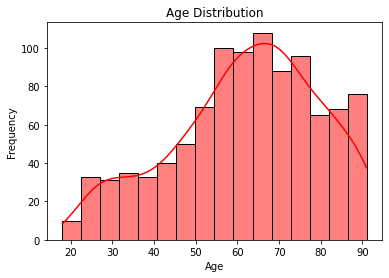

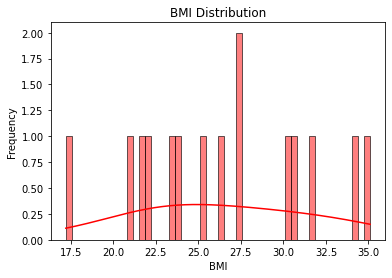

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a Pandas DataFrame
data = pd.read_csv('merged_bmi_age.csv')

# Extract the age and BMI columns
age = data['age']
bmi = data['bmi']

# Define the maximum figure size (adjust as needed)
max_fig_size = (16, 6)

# Sample data points for the plot to handle large datasets
sample_size = min(1000, len(data))  # Choose a suitable sample size (e.g., 1000)
sample_size2 = min(15, len(data))  # Choose a suitable sample size (e.g., 1000)
age_sample = age.sample(n=sample_size, random_state=42)
bmi_sample = bmi.sample(n=sample_size2, random_state=42)

# Create a figure for Age Distribution
fig1, ax1 = plt.subplots()
sns.histplot(age_sample, kde=True, ax=ax1, color='red')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')
ax1.set_title('Age Distribution')

# Create a figure for BMI Distribution
fig2, ax2 = plt.subplots()
sns.histplot(bmi_sample, kde=True, bins=50, ax=ax2, color='red')
ax2.set_xlabel('BMI')
ax2.set_ylabel('Frequency')
ax2.set_title('BMI Distribution')

plt.show()


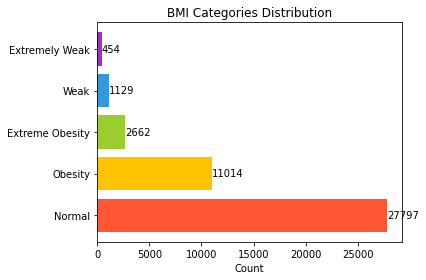

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame with subjects' BMI and groups
# data = pd.DataFrame({
#     'SubjectID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'AdmissionID': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
#     'BMI': [28.5, 35.2, 22.8, 40.1, 18.9, 34.7, 23.5, 28.0, 27.6, 31.3],
#     'Group': ['A', 'B', 'B', 'A', 'C', 'C', 'C', 'B', 'A', 'B']
# })

# Read the CSV file into a Pandas DataFrame
data = pd.read_csv('merged_bmi_age.csv')

# Function to categorize BMI into groups
def categorize_bmi(bmi):
    if bmi >= 40:
        return 'Extreme Obesity'
    elif 30 <= bmi < 40:
        return 'Obesity'
    elif 18.5 <= bmi < 30:
        return 'Normal'
    elif 25 <= bmi < 18.5:
        return 'Overweight'
    elif 16 <= bmi < 25:
        return 'Weak'
    else:
        return 'Extremely Weak'

# Categorize BMI values and add a new column 'BMI_Category' to the DataFrame
data['BMI_Category'] = data['bmi'].apply(categorize_bmi)

# Count the occurrences of each BMI category
bmi_counts = data['BMI_Category'].value_counts()

# Create a horizontal bar chart with custom colors
fig, ax = plt.subplots()
custom_colors = ['#FF5733', '#FFC300', '#9ACD32', '#3498DB', '#9932CC', '#C0C0C0']

ax.barh(bmi_counts.index, bmi_counts, color=custom_colors)

# Add labels to the bars
for i, v in enumerate(bmi_counts):
    ax.text(v + 0.5, i, str(v), va='center')

ax.set_xlabel('Count')
ax.set_title('BMI Categories Distribution')

plt.tight_layout()

# Save the plot to a file (e.g., PNG or PDF)
plt.savefig('bmi_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

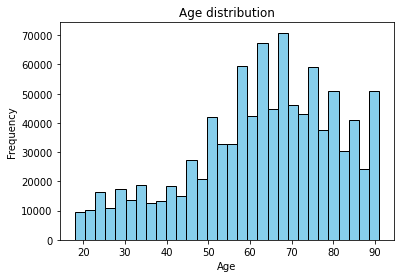

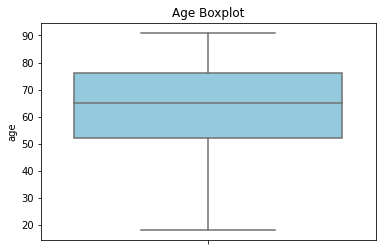

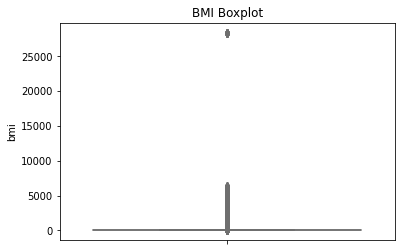

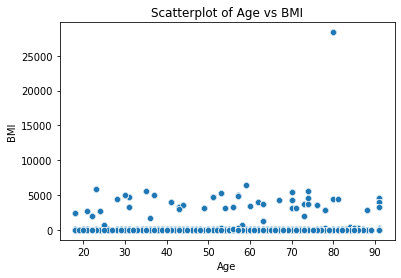

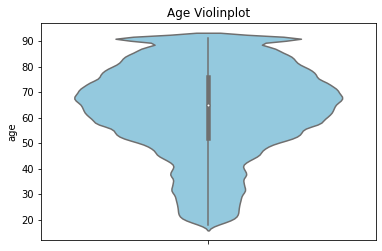

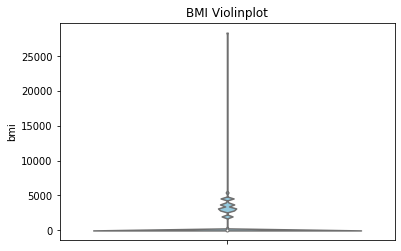

In [38]:
df = pd.read_csv('merged_bmi_age.csv')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Histogram for Age
plt.figure()
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


# Boxplot for Age
plt.figure()
sns.boxplot(data=df, y='age', color='skyblue')
plt.title('Age Boxplot')
plt.show()

# Boxplot for BMI
plt.figure()
sns.boxplot(data=df, y='bmi', color='skyblue')
plt.title('BMI Boxplot')
plt.show()

# Scatterplot of Age vs BMI
plt.figure()
sns.scatterplot(data=df, x='age', y='bmi')
plt.title('Scatterplot of Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

# Violin Plot for Age
plt.figure()
sns.violinplot(data=df, y='age', color='skyblue')
plt.title('Age Violinplot')
plt.show()

# Violin Plot for BMI
plt.figure()
sns.violinplot(data=df, y='bmi', color='skyblue')
plt.title('BMI Violinplot')
plt.show()


# End connection

In [42]:
# Close the cursor and connection
cur.close()
connection.close()

# Loading files

In [13]:
gxray_dicom = pd.read_csv(PATH1+PATH2+"gxray_dicom.csv")

## EDA

In [ ]:
#number of patients

print("Number of patients: ", gxray_dicom['subject_id'].nunique())  #40305 unique patients
print(gxray_dicom.head().to_string())

Number of patients:  40305
   Unnamed: 0                                      dicom_id  subject_id  study_id PerformedProcedureStepDescription ViewPosition  Rows  Columns   StudyDate   StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning PatientOrientationCodeSequence_CodeMeaning   time_formatted             time  time_diff_seconds time_diff        StudyDateTime        poe_id  poe_seq   hadm_id            ordertime order_type order_subtype transaction_type discontinue_of_poe_id discontinued_by_poe_id order_provider_id order_status
0           0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267                CHEST (PA AND LAT)           PA  3056     2544  2180-05-06  213014.531                CHEST (PA AND LAT)             postero-anterior                                      Erect  0 days 21:30:14  0 days 20:53:47             2187.0  00:36:27  2180-05-06 21:30:14   10000032-14       14  22595853  2180-05-06 20:53:47  Radiology  General Xray       

# Number of images per patient

In [33]:
#counting images per subject

# grouped_gxray_dicom = gxray_dicom.groupby('subject_id').size().reset_index(name='count')
# print(grouped_gxray_dicom)

# grouped_gxray_dicom.plot(x='subject_id', y='count', kind='bar', ascending=False)
# plt.show()


<AxesSubplot:xlabel='subject_id'>

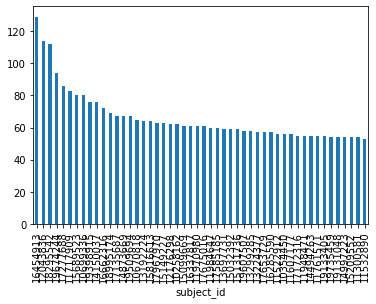

In [ ]:
#number of study_id/images sessions per subject
gxray_dicom.groupby('subject_id')['study_id'].nunique().sort_values(ascending=False).head(50).plot(kind='bar')

In [ ]:
gxray_dicom.groupby('subject_id')['study_id'].nunique().sort_values(ascending=False).head(50)


subject_id
16454913    129
12043836    114
18295542    112
19674244     94
17277688     86
11717909     83
15689523     80
10699336     80
19398915     76
14150037     76
16662316     72
18995174     69
17135687     67
14873669     67
19509694     67
10670818     65
13192224     64
15816613     64
17967970     63
15149227     63
12176298     62
10258162     62
15099669     61
16337817     61
11970980     61
17675016     61
11984647     60
17585185     60
13697731     59
15032392     59
15131736     59
19607507     58
13299285     58
13224377     57
17653729     57
16285590     57
11522912     56
10354450     56
11607177     56
17172316     55
11948471     55
14494263     55
11761571     55
19133405     55
19735459     54
19131048     54
14997223     54
15209552     54
11300581     54
11532890     53
Name: study_id, dtype: int64

# Merging gxray_dicom with discharge notes

with subject id and admission id

In [ ]:
discharge_df = pd.read_csv(PATH1+"discharge.csv")
gxray_dicom.shape

(215741, 29)

In [ ]:
#merging all columns considering subject_id and hadm_id
merged_df = pd.merge(gxray_dicom, discharge_df, on=['subject_id', 'hadm_id'], how='inner')
merged_df.shape  #(196068, 35) images
merged_df['subject_id'].nunique()  #35152 patient

35152

In [ ]:
#to drop
merged_df = merged_df.drop(['discontinue_of_poe_id', 'discontinued_by_poe_id',
       'order_provider_id', 'order_status'],axis=1)  #from 35 to 31 columns

In [32]:
# merged_df.head()

In [ ]:
PATH3 = "/merged/"
merged_df.to_csv(PATH1+PATH3+"gxray_dicom_discharge.csv")

In [48]:
merged_df = pd.read_csv(PATH1+PATH3+"gxray_dicom_discharge.csv")

# MERGING gxray_dicom_discharge with bmi_age df

In [61]:
merged_df.shape

(196068, 32)

In [59]:
#adding bmi and age info
bmi_age_xray_dicom_discharge_df = pd.merge(merged_df, merged_bmi_age, on=['subject_id', 'hadm_id'], how='inner')
bmi_age_xray_dicom_discharge_df.shape  #(17744, 38)

(17744, 38)

In [65]:
#adding age info
age_xray_dicom_discharge_df = pd.merge(merged_df, age_q, on=['subject_id', 'hadm_id'], how='inner')
age_xray_dicom_discharge_df.shape  #88971



(88971, 39)

In [68]:
age_xray_dicom_discharge_df = age_xray_dicom_discharge_df.drop_duplicates()
age_xray_dicom_discharge_df.shape  #(88971, 39)

(88971, 39)

In [69]:
age_xray_dicom_discharge_df.to_csv(PATH1+"age_xray_dicom_discharge_df.csv")